In [1]:
#import ydata_profiling

SEED = 2022
#!/usr/bin/env python
import sys
import os
sys.path.append('src/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA
import logging
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
import time
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

# Load the data

In [2]:
train_df = pd.read_csv('Data/housing_price/train.csv', index_col=0)

In [3]:
train_df.reset_index(inplace=True, drop=True)

In [4]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
drop_features = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [6]:
train_df.drop(columns=drop_features, inplace=True)

In [7]:
def fit_processor(X_train, numeric_features, categorical_features):
    """
    Applies Simple Imputer to Categorical Features
    Applies One Hot Encoding to Categorical Features
    Applies Quantile Scaling to Numeric Features
    Returns and writes pickle file of the complete preprocessor

    Parameters
    ----------
    X_train : numpy
        Training Data in NumPy format
    numeric_features : list[string]
        List of Numeric Features
    categorical_features: list[string]
        List of Categorical Features

    Returns
    -------
    preprocessor : sklearn.Preprocessor
        sklearn preprocessor fit on the training set
    """
    pipe_num = Pipeline([
        ('impute', SimpleImputer(strategy='mean')),
        ('scaler',  MinMaxScaler())
    ])
    pipe_cat = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]) 
    preprocessor = ColumnTransformer([
        ('num', pipe_num, numeric_features),
        ('cat', pipe_cat, categorical_features)
    ])

    norm_X_train = preprocessor.fit(X_train)

    return preprocessor

In [8]:
def format_data(df):
    """
    Format the Data into X, y to setup different variables for the Machine Learning pipeline

    Parameters
    ----------
    df : DataFrame
        DataFrame to separate into X,y

    Returns
    -------
    Xy : tuple[numpy, numpy]
        NumPy arrays of features and predictor

    """
    y = df['SalePrice']
    y = y.to_numpy()
    col_names = df.columns.tolist()
    col_names.remove('SalePrice')
    X = df[col_names]

    return X,y

# CHKN NOTES
- train validation and test - 3 fundos
- split it 80 20
- crossvalidation while trainng
- tune hyper paras of model
- but method to it are diff across each thing
- best one to use for tabular is called stratified k fold - time is time- why bother????
- CROSSValidate

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
features = train_df.columns.to_list()

In [12]:
features.remove('SalePrice')

In [13]:
X = train_df[features]
y = train_df[['SalePrice']]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [15]:
# Prepare columns
features = X_train.columns.to_list()
df_numerical_features = X_train.select_dtypes(include='number')
df_categorical_features = X_train.select_dtypes(include='object')

# preprocess
numerical_features = df_numerical_features.columns.to_list()
categorical_features = df_categorical_features.columns.to_list()
processor = fit_processor(X_train[features],numerical_features, categorical_features)

In [16]:
norm_X_train = processor.transform(X_train)

In [17]:
norm_X_test = processor.transform(X_test)

In [25]:
processor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['MSSubClass', 'LotFrontage', 'LotArea',
                                  'OverallQual', 'OverallCond', 'YearBuilt',
                                  'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                                  'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                                  '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                                  'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
                                  'Fu...
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'Neighborhood', 'Condition1',
                                  'Condition2', 'BldgType', 'HouseStyle',
                                  'RoofStyle', 'RoofMatl', 'Exterior1st',
                                  'Exterior2nd', 'MasVnrType', 'ExterQual',
                                  'ExterCond', 'Foundation', 'BsmtQual',
                                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual', ...])])

In [18]:
X_test.shape

(292, 74)

In [19]:
y_train.shape

(1168, 1)

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Chknnotes2
1. Decide the features
2. Train test split data into X, y
3. Decide the preprocessing
4. Implement crossvalidation
5. test

In [21]:
params = {
    'n_estimators':[10,50,100],
    'max_depth':[50,100,200],
    'min_samples_split':[2,3,4]    
}

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
skf = KFold(n_splits=10, random_state=SEED, shuffle=True)

In [23]:
clf = GridSearchCV(RandomForestRegressor(), params, cv=skf)

In [24]:
clf.fit(norm_X_train, y_train.values.ravel())

GridSearchCV(cv=KFold(n_splits=10, random_state=69, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [50, 100, 200],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 50, 100]})

In [26]:
clf.best_params_

{'max_depth': 200, 'min_samples_split': 2, 'n_estimators': 100}

In [27]:
clf.score(norm_X_train, y_train)

0.9806476382486176

In [28]:
clf.score(norm_X_test, y_test)

0.8733114838928443

## Baseline Modeling

In [50]:
from sklearn.dummy import DummyRegressor

In [51]:
dummy = DummyRegressor(strategy = 'mean').fit(norm_X_train, y_train)

Dummy model on the Train Data

In [52]:
dummy.score(norm_X_train, y_train)

0.0

In [53]:
dummy.score(norm_X_test, y_test)

-0.0018966784172922413

## Prospective Data

In [29]:
test_df = pd.read_csv('Data/housing_price/test.csv', index_col=0)

In [30]:
test_df.reset_index(inplace=True, drop=True)

In [31]:
test_df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [32]:
test_df = test_df[features]

In [33]:
test_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,120,0,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,34,0,0,0,0,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,36,0,0,0,0,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,...,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,32,0,0,0,0,700,7,2006,WD,Normal


In [34]:
test_df = test_df.fillna(0)

In [35]:
norm_X_test_final = processor.transform(test_df)


In [36]:
norm_X_test_final

array([[0.        , 0.20205479, 0.04824604, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.20547945, 0.06060904, ..., 0.        , 1.        ,
        0.        ],
       [0.23529412, 0.18150685, 0.05856645, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 0.4760274 , 0.08740564, ..., 0.        , 0.        ,
        0.        ],
       [0.38235294, 0.14041096, 0.04272593, ..., 0.        , 1.        ,
        0.        ],
       [0.23529412, 0.18150685, 0.03892122, ..., 0.        , 1.        ,
        0.        ]])

In [37]:
y_predict = clf.predict(norm_X_test_final)

In [38]:
y_final = pd.DataFrame(y_predict, columns=['SalePrice'])

In [39]:
final_df = pd.concat([test_df, y_final], axis=1)

In [40]:
final_df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1454,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2006,WD,Normal,85303.08
1455,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2006,WD,Abnorml,87632.00
1456,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2006,WD,Abnorml,157919.24
1457,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,700,7,2006,WD,Normal,113599.00
1458,60,RL,74.0,9627,Pave,Reg,Lvl,AllPub,Inside,Mod,...,0,0,0,0,0,11,2006,WD,Normal,229857.58


In [41]:
import shap
shap.initjs()

In [42]:
explainer = shap.Explainer(clf.best_estimator_)
shap_values = explainer(norm_X_test)

In [46]:
features_processed = processor.get_feature_names_out()

In [49]:
train_df['GrLivArea'].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

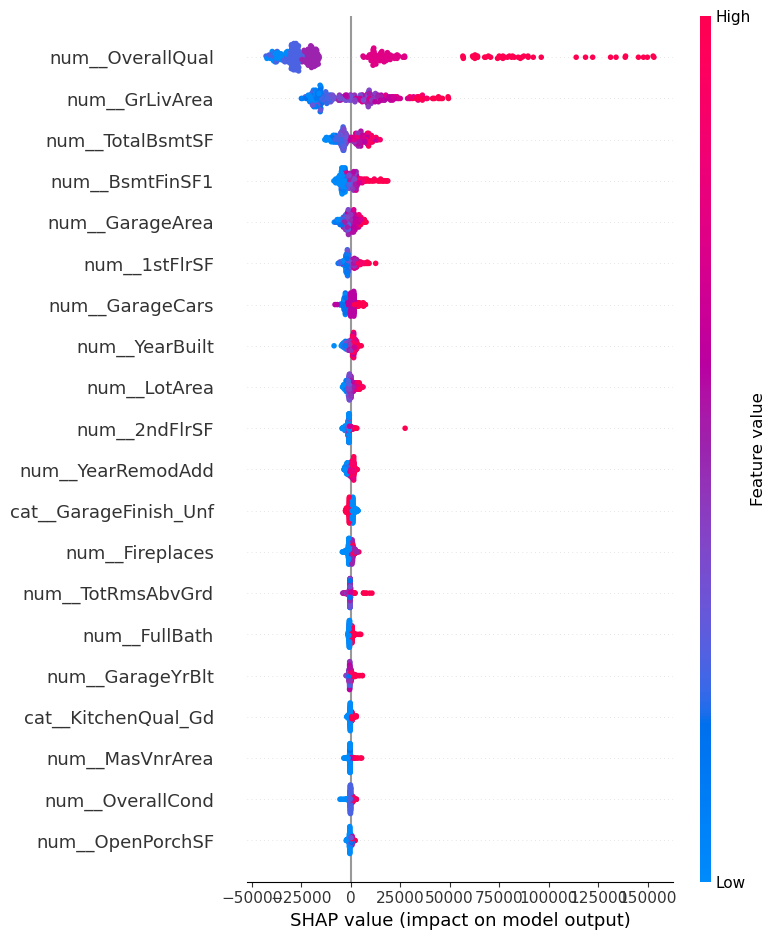

In [48]:
shap.summary_plot(shap_values, norm_X_test, feature_names=features_processed)